In [525]:
import sklearn
import pandas as pd
import numpy as np

In [526]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, cross_val_score

In [527]:
from plotnine import ggplot, aes, geom_point, geom_line, geom_histogram, geom_bar, labs, geom_smooth, ggtitle

In [528]:
df = pd.read_csv('Hitters.csv')
df = df.dropna(subset = ['Salary'])
df.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N


# Part I: Different Model Specs

In [529]:
#1A Linear

X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

ct = ColumnTransformer(
    [("dm", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
      make_column_selector(dtype_include = object)),
     ("st", StandardScaler(), 
      make_column_selector(dtype_include = np.number))], 
    remainder = "drop"
).set_output(transform = "pandas")

linear_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

linear_pipeline_fitted = linear_pipeline.fit(X, y)
coef = linear_pipeline_fitted.named_steps['linear_regression'].coef_
linear_df = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Linear Coef': coef})
linear_df

,Variable,Linear Coef
0,dm__League_A,-31.299712
1,dm__League_N,31.299712
2,dm__Division_E,58.424623
3,dm__Division_W,-58.424623
4,dm__NewLeague_A,12.381163
5,dm__NewLeague_N,-12.381163
6,st__AtBat,-291.094556
7,st__Hits,337.830479
8,st__HmRun,37.853837
9,st__Runs,-60.572479


 - Pairs of dummy variables seem to have a direct effect on one another (only need to include one of pair in model)
 - Hits, Walks, CRuns, and CRBI all have a large positive effect on Salary
 - AtBat, CATBAT, and CWalks have seemingly negative effects on Salary
 
 Interpretation: For every one unit increase in Hits(standardized), there is an associated 337.83 unit increase in Salary, after adjusting for the other predictor variables. 

In [530]:
mse_scores = cross_val_score(linear_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores = np.abs(mse_scores)
mse_scores.mean()

121136.31031816888

In [531]:
#1B Ridge

X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge())]
)

values = [100, 120, 150, 175, 200]
lambdas = {'ridge_regression__alpha': values}
gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"ridge lambda": values, "scores": gscv_scores})

,ridge lambda,scores
0,100,0.385012
1,120,0.385890
2,150,0.386519
3,175,0.386582
4,200,0.386328


In [532]:
ridge_pipeline = Pipeline(
    [("preprocessing", ridge_ct),
     ("ridge_regression", Ridge(alpha = 175))]
)

ridge_pipeline_fitted = ridge_pipeline.fit(X, y)
coef = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_
ridge_df = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Ridge Coef': coef})
ridge_df

,Variable,Ridge Coef
0,dm__League_A,-8.253888
1,dm__League_N,8.253888
2,dm__Division_E,29.115297
3,dm__Division_W,-29.115297
4,dm__NewLeague_A,-4.376371
5,dm__NewLeague_N,4.376371
6,st__AtBat,9.994456
7,st__Hits,40.034590
8,st__HmRun,4.071842
9,st__Runs,27.711556


- The magnitude of all coefficients have decreased
- There is still a direct relationship between countering dummy variable
- Aside from the dummy variables there is now only one negative coefficient (Errors)

Interpretation: For every one unit increase in Hits(standardized), there is an associated ridge regularized(lambda = 175) effect of 40.03 units, after adjusting for the remaining predictor variables. 

In [533]:
mse_scores = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores = np.abs(mse_scores)
mse_scores.mean()

121579.48212866877

In [534]:
#1C Lasso

X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso())]
)

values = [10, 20, 30, 40]
lambdas = {'lasso_regression__alpha': values}
gscv = GridSearchCV(lasso_pipeline, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"lasso lambda": values, "scores": gscv_scores})

,lasso lambda,scores
0,10,0.369523
1,20,0.377168
2,30,0.369527
3,40,0.366333


In [535]:
lasso_pipeline = Pipeline(
    [("preprocessing", lasso_ct),
     ("lasso_regression", Lasso(alpha = 20))]
)

lasso_pipeline_fitted = lasso_pipeline.fit(X, y)
coef = lasso_pipeline_fitted.named_steps['lasso_regression'].coef_
lasso_df = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Lasso Coef': coef})
lasso_df

,Variable,Lasso Coef
0,dm__League_A,-0.000000e+00
1,dm__League_N,0.000000e+00
2,dm__Division_E,5.718083e+01
3,dm__Division_W,-1.757378e-12
4,dm__NewLeague_A,-0.000000e+00
5,dm__NewLeague_N,0.000000e+00
6,st__AtBat,0.000000e+00
7,st__Hits,8.402579e+01
8,st__HmRun,0.000000e+00
9,st__Runs,0.000000e+00


- The magnitude of all coefficients have further decreased compared to ridge
- There is no longer a 1:1 relationship between  dummy variables
- The majority of coefficients have approximated 0, indicating that these may be less influential variables

Interpretation: For every one unit increase in Hits(standardized), there is an associated lasso regularized(lambda = 20) effect of 84.026 units, after adjusting for the remaining predictor variables. 

In [536]:
mse_scores = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores = np.abs(mse_scores)
mse_scores.mean()

122381.4940671996

In [537]:
#1D Elastic Net

X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

elastic_pipeline = Pipeline(
    [("preprocessing", elastic_ct),
     ("elastic_regression", ElasticNet())]
)

lambdas = [0.5, 1, 2]
a = [0.1, 0.2, 0.3]
lambdas_a = {'elastic_regression__alpha': lambdas, 'elastic_regression__l1_ratio' : a}
gscv = GridSearchCV(elastic_pipeline, lambdas_a, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
gscv_scores

array([0.38477201, 0.38406479, 0.38317201, 0.38651095, 0.38664335,
       0.38655737, 0.37913564, 0.38127313, 0.38315066])

In [538]:
elastic_pipeline = Pipeline(
    [("preprocessing", lasso_ct),
     ("elastic_regression", ElasticNet(alpha = 1, l1_ratio = 0.2))]
)

elastic_pipeline_fitted = elastic_pipeline.fit(X, y)
coef = elastic_pipeline_fitted.named_steps['elastic_regression'].coef_
elastic_df = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Elastic Coef': coef})
elastic_df

,Variable,Elastic Coef
0,dm__League_A,-7.248569
1,dm__League_N,7.248595
2,dm__Division_E,26.103984
3,dm__Division_W,-26.103971
4,dm__NewLeague_A,-4.116523
5,dm__NewLeague_N,4.116546
6,st__AtBat,12.179419
7,st__Hits,37.450668
8,st__HmRun,5.609999
9,st__Runs,27.011028


- The magnitude of the coefficients has increased again, similar to ridge model
- The 1:1 relationship between  dummy variables has returned
- Just like in Ridge, aside from the dummy variables there is now only one negative coefficient (Errors)

Interpretation: For every one unit increase in Hits(standardized), there is an associated elastic net regularized(lambda = 1, a = 0.20) effect of 37.4507 units, after adjusting for the remaining predictor variables. 

In [464]:
mse_scores = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_scores = np.abs(mse_scores)
mse_scores.mean()

121500.81646251371

# Part II. Variable Selection

In [487]:
coef_df = pd.concat([linear_df, ridge_df.iloc[:, 1], lasso_df.iloc[:, 1], elastic_df.iloc[:, 1]], axis = 1)
coef_df

,Variable,Linear Coef,Ridge Coef,Lasso Coef,Elastic Coef
0,dm__League_A,-31.299712,-8.253888,-0.000000e+00,-7.248569
1,dm__League_N,31.299712,8.253888,0.000000e+00,7.248595
2,dm__Division_E,58.424623,29.115297,5.718083e+01,26.103984
3,dm__Division_W,-58.424623,-29.115297,-1.757378e-12,-26.103971
4,dm__NewLeague_A,12.381163,-4.376371,-0.000000e+00,-4.116523
5,dm__NewLeague_N,-12.381163,4.376371,0.000000e+00,4.116546
6,st__AtBat,-291.094556,9.994456,0.000000e+00,12.179419
7,st__Hits,337.830479,40.034590,8.402579e+01,37.450668
8,st__HmRun,37.853837,4.071842,0.000000e+00,5.609999
9,st__Runs,-60.572479,27.711556,0.000000e+00,27.011028


Based on the above results...

Most Important Numeric Variable: Hits (st__Hits)

5 Most Important Numeric Variables: Hits, CRuns, CRBI, Walks, PutOuts

Most Important Categorical Variable: Division(dm__Division_E and dm__Division_W)

In [488]:
#Model Specification 1

X = df[["Hits"]]
y = df["Salary"]

#Linear Model 1

linear_pipeline_fitted = linear_pipeline.fit(X, y)
coef = linear_pipeline_fitted.named_steps['linear_regression'].coef_
linear_df1 = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Linear Coef 1': coef})

linear_mse = cross_val_score(linear_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
linear_mse = np.abs(mse_scores)
linear_r2 = cross_val_score(linear_pipeline, X, y, cv = 5, scoring = 'r2')
linear_mse1 = linear_mse.mean()

linear_mse.mean(), linear_r2[0]

(122381.4940671996, 0.3736363262696428)

In [467]:
#Ridge Model 1

ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge())]
)

values = [40, 45, 50]
lambdas = {'ridge_regression__alpha': values}
gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"ridge lambda": values, "scores": gscv_scores})

ridge_pipeline = Pipeline(
    [("preprocessing", ridge_ct),
     ("ridge_regression", Ridge(alpha = 45))]
)

ridge_pipeline_fitted = ridge_pipeline.fit(X, y)
coef = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_
ridge_df1 = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Ridge Coef 1': coef})

ridge_mse = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
ridge_mse = np.abs(ridge_mse)
ridge_r2 = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
ridge_mse1 = ridge_mse.mean()

ridge_mse.mean(), ridge_r2[0]

(172758.22116645527, 0.33764525435031456)

In [468]:
#Lasso Model 1

lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso())]
)

values = [20, 25, 30]
lambdas = {'lasso_regression__alpha': values}
gscv = GridSearchCV(lasso_pipeline, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"lasso lambda": values, "scores": gscv_scores})

lasso_pipeline = Pipeline(
    [("preprocessing", lasso_ct),
     ("lasso_regression", Lasso(alpha = 25))]
)

lasso_mse = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
lasso_mse = np.abs(lasso_mse)
lasso_r2 = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'r2')
lasso_mse1 = lasso_mse.mean()

lasso_mse.mean(), lasso_r2[0]

(173408.32371096587, 0.34875849229534917)

In [469]:
#Elastic Net Model 1

elastic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_regression", ElasticNet())]
)

lambdas = [0.9, 1, 1.1]
a = [0.75, 0.80, 0.85]
lambdas_a = {'elastic_regression__alpha': lambdas, 'elastic_regression__l1_ratio' : a}
gscv = GridSearchCV(elastic_pipeline, lambdas_a, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
gscv_scores

elastic_pipeline = Pipeline(
    [("preprocessing", elastic_ct),
     ("elastic_regression", ElasticNet(alpha = 1, l1_ratio = 0.80))]
)

elastic_mse = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
elastic_mse = np.abs(elastic_mse)
elastic_r2 = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'r2')
elastic_mse1 = elastic_mse.mean()

elastic_mse.mean(), elastic_r2[0]

(172733.69049703167, 0.3392803211211548)

In [470]:
#Model Specification 2

X = df[["Hits", "CRuns", "CRBI", "Walks", "PutOuts"]]
y = df["Salary"]

#Linear Model 2

linear_pipeline_fitted = linear_pipeline.fit(X, y)
coef = linear_pipeline_fitted.named_steps['linear_regression'].coef_
linear_df2 = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Linear Coef 2': coef})

linear_mse = cross_val_score(linear_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
linear_mse = np.abs(mse_scores)
linear_r2 = cross_val_score(linear_pipeline, X, y, cv = 5, scoring = 'r2')
linear_mse2 = linear_mse.mean()

linear_mse.mean(), linear_r2[0]

(121500.81646251371, 0.508298511674809)

In [471]:
#Ridge Model 2

ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge())]
)

values = [80, 85, 90]
lambdas = {'ridge_regression__alpha': values}
gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"ridge lambda": values, "scores": gscv_scores})

ridge_pipeline = Pipeline(
    [("preprocessing", ridge_ct),
     ("ridge_regression", Ridge(alpha = 85))]
)

ridge_pipeline_fitted = ridge_pipeline.fit(X, y)
coef = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_
ridge_df2 = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Ridge Coef 2': coef})

ridge_mse = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
ridge_mse = np.abs(ridge_mse)
ridge_r2 = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
ridge_mse2 = ridge_mse.mean()

ridge_mse.mean(), ridge_r2[0]

(119072.11514897882, 0.5608865060762285)

In [472]:
#Lasso Model 2

lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso())]
)

values = [15, 20, 25]
lambdas = {'lasso_regression__alpha': values}
gscv = GridSearchCV(lasso_pipeline, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"lasso lambda": values, "scores": gscv_scores})

lasso_pipeline = Pipeline(
    [("preprocessing", lasso_ct),
     ("lasso_regression", Lasso(alpha = 20))]
)

lasso_mse = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
lasso_mse = np.abs(lasso_mse)
lasso_r2 = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'r2')
lasso_mse2 = lasso_mse.mean()

lasso_mse.mean(), lasso_r2[0]

(122349.44525968086, 0.5386032153193024)

In [473]:
#Elastic Net Model 2

elastic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_regression", ElasticNet())]
)

lambdas = [0.10, 0.50, 1]
a = [0.01, 0.05, 0.10]
lambdas_a = {'elastic_regression__alpha': lambdas, 'elastic_regression__l1_ratio' : a}
gscv = GridSearchCV(elastic_pipeline, lambdas_a, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
gscv_scores

elastic_pipeline = Pipeline(
    [("preprocessing", elastic_ct),
     ("elastic_regression", ElasticNet(alpha = 0.50, l1_ratio = 0.05))]
)

elastic_mse = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
elastic_mse = np.abs(elastic_mse)
elastic_r2 = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'r2')
elastic_mse2 = elastic_mse.mean()

elastic_mse.mean(), elastic_r2[2]

(119383.6033504443, 0.5538057445636746)

In [474]:
#Model Specification 3

X = df[["Hits", "CRuns", "CRBI", "Walks", "PutOuts", "Division"]]
y = df["Salary"]

ctA = ColumnTransformer(
    [("dm", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
      make_column_selector(dtype_include = object)),
     ("st", StandardScaler(), 
      make_column_selector(dtype_include = np.number))], 
    remainder = "drop"
).set_output(transform = "pandas")

ctB = ColumnTransformer(
  [("interaction", PolynomialFeatures(interaction_only = True),
    ['dm__Division_E', 'dm__Division_W','st__Hits','st__CRuns',
     'st__CRBI', 'st__Walks', 'st__PutOuts'])],
  remainder = "drop"
).set_output(transform = "pandas")

#Linear Model 3

linear_pipeline_inter = Pipeline(
  [("preprocessing", ctA),
   ("interaction", ctB),
  ("linear_regression", LinearRegression())]
)

linear_pipeline_fitted = linear_pipeline.fit(X, y)
coef = linear_pipeline_fitted.named_steps['linear_regression'].coef_
linear_df3 = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Linear Coef' : coef})


linear_mse = cross_val_score(linear_pipeline_inter, X, y, cv = 5, scoring = 'neg_mean_squared_error')
linear_mse = np.abs(mse_scores)
linear_r2 = cross_val_score(linear_pipeline_inter, X, y, cv = 5, scoring = 'r2')
linear_mse3 = linear_mse.mean()

linear_mse.mean(), linear_r2[2]

(121500.81646251371, 0.7234939264832366)

In [475]:
#Ridge Model 3

ridge_pipeline_inter = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("ridge_regression", Ridge())]
)

values = [50, 55, 60]
lambdas = {'ridge_regression__alpha': values}
gscv = GridSearchCV(ridge_pipeline_inter, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"ridge lambda": values, "scores": gscv_scores})

ridge_pipeline_inter = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("ridge_regression", Ridge(alpha = 55))]
)

ridge_pipeline_fitted = ridge_pipeline.fit(X, y)
coef = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_
ridge_df3 = pd.DataFrame({'Variable': ct.fit_transform(X).columns, 'Ridge Coef 3': coef})

ridge_mse = cross_val_score(ridge_pipeline_inter, X, y, cv = 5, scoring = 'neg_mean_squared_error')
ridge_mse = np.abs(ridge_mse)
ridge_r2 = cross_val_score(ridge_pipeline_inter, X, y, cv = 5, scoring = 'r2')
ridge_mse3 = ridge_mse.mean()

ridge_mse.mean(), ridge_r2[2]

(90948.4173968908, 0.7083346400518443)

In [476]:
#Lasso Model 3

lasso_pipeline_inter = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("lasso_regression", Lasso())]
)

values = [15, 20, 25]
lambdas = {'lasso_regression__alpha': values}
gscv = GridSearchCV(lasso_pipeline_inter, lambdas, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"lasso lambda": values, "scores": gscv_scores})

lasso_pipeline_inter = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("lasso_regression", Lasso(alpha = 20))]
)

lasso_mse = cross_val_score(lasso_pipeline_inter, X, y, cv = 5, scoring = 'neg_mean_squared_error')
lasso_mse = np.abs(lasso_mse)
lasso_r2 = cross_val_score(lasso_pipeline_inter, X, y, cv = 5, scoring = 'r2')
lasso_mse3 = lasso_mse.mean()

lasso_mse.mean(), lasso_r2[2]

(92443.44349502376, 0.6921031320820076)

In [477]:
#Elastic Net Model 3

elastic_pipeline_inter = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("elastic_regression", ElasticNet())]
)

lambdas = [0.35, 0.40, 0.45]
a = [0.30, 0.35, 0.40]
lambdas_a = {'elastic_regression__alpha': lambdas, 'elastic_regression__l1_ratio' : a}
gscv = GridSearchCV(elastic_pipeline_inter, lambdas_a, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
gscv_scores

elastic_pipeline_inter = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("elastic_regression", ElasticNet(alpha = 0.40, l1_ratio = 0.35))]
)

elastic_mse = cross_val_score(elastic_pipeline_inter, X, y, cv = 5, scoring = 'neg_mean_squared_error')
elastic_mse = np.abs(elastic_mse)
elastic_r2 = cross_val_score(elastic_pipeline_inter, X, y, cv = 5, scoring = 'r2')
elastic_mse3 = elastic_mse.mean()

elastic_mse.mean(), elastic_r2[2]

(90953.63628056264, 0.7081450312225999)

In [490]:
mse_data = {
    'Model': ['1', '1', '1', '1', '2', '2', '2', '2', '3', '3', '3', '3'],
    'Type': ['Linear', 'Ridge', 'Lasso', 'Elastic', 'Linear', 'Ridge', 'Lasso', 'Elastic', 'Linear', 'Ridge', 'Lasso', 'Elastic'],
    'MSE': [linear_mse1, ridge_mse1, lasso_mse1, elastic_mse1, linear_mse2, ridge_mse2, lasso_mse2, elastic_mse2, linear_mse3, ridge_mse3, lasso_mse3, elastic_mse3]
}

mse_df = pd.DataFrame(mse_data)
mse_df

,Model,Type,MSE
0,1,Linear,122381.494067
1,1,Ridge,172758.221166
2,1,Lasso,173408.323711
3,1,Elastic,172733.690497
4,2,Linear,121500.816463
5,2,Ridge,119072.115149
6,2,Lasso,122349.445260
7,2,Elastic,119383.603350
8,3,Linear,121500.816463
9,3,Ridge,90948.417397


Based on the MSE values, the best performing models were the penalized regression models (Ridge, Lasso, and Elastic) with the 3rd Model variables (The five best numeric variables and their interactions with the one best categorical variable).

1. Model 3 Elastic MSE: 90953.636281
2. Model 3 Ridge MSE: 90948.417397
3. Model 3 Lasso MSE: 92443.443495

# Part III. Discussion

In [489]:
#A. Ridge

variable_df = linear_df.iloc[:,0]
coef_df = pd.merge(variable_df, linear_df1, on = 'Variable', how = 'left').merge(ridge_df1, on = 'Variable', how = 'left').merge(linear_df2, on = 'Variable').merge(ridge_df2, on = 'Variable').merge(linear_df3, on = 'Variable').merge(ridge_df3, on = 'Variable')
coef_df

,Variable,Linear Coef 1,Ridge Coef 1,Linear Coef 2,Ridge Coef 2,Linear Coef,Ridge Coef 3
0,st__Hits,197.517786,168.659668,94.284750,77.138843,90.452518,75.213494
1,st__Walks,NaN,NaN,54.519735,57.963888,52.577871,56.695611
2,st__CRuns,NaN,NaN,87.568734,90.805193,72.505401,89.246177
3,st__CRBI,NaN,NaN,127.643813,97.116292,141.937660,98.179107
4,st__PutOuts,NaN,NaN,74.377983,61.419132,73.900128,61.321010


The MSE values showed that Ridge outperformed OLS on models 2 and 3, but had a higher MSE for model 1. This is likely due to the lack of complexity in the single predictor model. The table above shows the Linear and Ridge Coefficients for each of the 3 Models. There tends to be a slight decrease in Coefficients for Ridge, however it is not as pronounced as we would've expected. Part I showed a clear decrease in magnitude of the coefficients when using Ridge compard to OLS. 

In [ ]:
#B. Lasso

Lasso tended to be the weakest of the three penalized regression techniques across the three different models. Like the other regression techniques, the MSE improved as the complexity of the model increased. The Lamnda values for Models 1, 2, and 3, were 25, 20, and 20 respectively. This was by far the most consistent argument across each of the penalized regression techniques.  

In [ ]:
#C. Elastic Net

The MSE dataframe confirms the theory that the Elastic Net produces the smallest MSE across all the regression techniques used. Elastic Net allows you to optimize the weights of the Ridge and LAsso penalty in order to minimize error in the regression. It only makes sense that Elastic Net outperformed both Ridge and Lasso. 

# Part IV: Final Model

In [511]:
#Final Model

X = df[["Hits", "CRuns", "CRBI", "Walks", "PutOuts", "Division"]]
y = df["Salary"]

ctA = ColumnTransformer(
    [("dm", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
      make_column_selector(dtype_include = object)),
     ("st", StandardScaler(), 
      make_column_selector(dtype_include = np.number))], 
    remainder = "drop"
).set_output(transform = "pandas")

ctB = ColumnTransformer(
  [("interaction", PolynomialFeatures(interaction_only = True),
    ['dm__Division_E', 'dm__Division_W','st__Hits','st__CRuns',
     'st__CRBI', 'st__Walks', 'st__PutOuts'])],
  remainder = "drop"
).set_output(transform = "pandas")

final_pipeline = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("elastic_regression", ElasticNet())]
)

lambdas = [0.80, 0.95, 1]
a = [0.15, 0.50, 0.75]
lambdas_a = {'elastic_regression__alpha': lambdas, 'elastic_regression__l1_ratio' : a}
gscv = GridSearchCV(final_pipeline, lambdas_a, cv = 5, scoring = 'r2')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
gscv_scores

final_pipeline = Pipeline(
    [("preprocessing", ctA),
     ("interaction", ctB),
     ("elastic_regression", ElasticNet(alpha = 0.40, l1_ratio = 0.35))]
)

final_mse = cross_val_score(final_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
final_mse = np.abs(final_mse)
final_r2 = cross_val_score(final_pipeline, X, y, cv = 5, scoring = 'r2')
final_mse3 = elastic_mse.mean()

final_mse.mean(), final_r2[2]

(90953.63628056264, 0.7081450312225999)

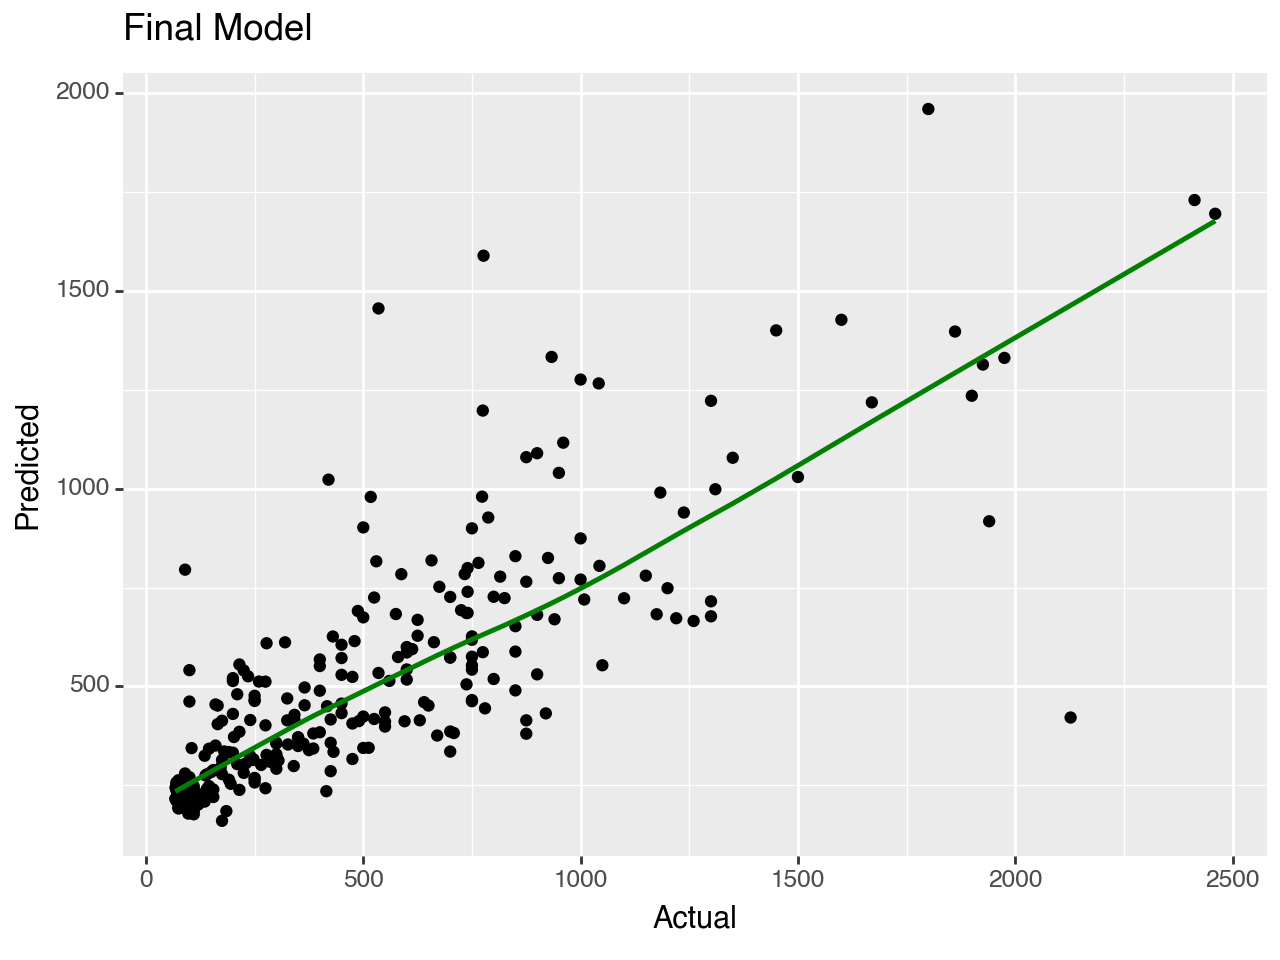

<Figure Size: (640 x 480)>

In [541]:
#Plot of Final Model

y_pred = final_pipeline.predict(X)
data = pd.DataFrame({'Actual': y, 'Predicted': y_pred})

(ggplot(data, aes(x = 'Actual', y = 'Predicted'))
+ geom_point()
+ geom_smooth(method = 'auto', se = False, color = 'green')
+ ggtitle('Final Model')
)